In [1]:
from nlprocessing import ProcessCorpus
import pandas as pd
from nltk.corpus import words
import gensim

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
data1 = pd.read_csv('../data/comments.csv', sep='|').dropna()
data2 = pd.read_csv('../data/more_comments.csv').dropna()
data = data1.append(data2, ignore_index=True)
data = data[~data.duplicated()]
data = data[data['subreddit'] != 'politics']
test = data['text']#.sample(n=10000)

In [3]:
corpus = ProcessCorpus()
corpus.fit(test, frequency=2)

In [4]:
model = gensim.models.LdaModel(
    corpus=corpus.gensim_corpus_filtered,
    id2word=corpus.gensim_dictionary,
    num_topics=10,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [15]:
coherence = gensim.models.CoherenceModel(
    model=model,
    texts=corpus.corpus,
    corpus=corpus.gensim_corpus
)
coherence.get_coherence()

0.5025058625378811

In [16]:
def find_perplexity_coherence(n_topics):
    model = gensim.models.LdaModel(
        corpus=corpus.gensim_corpus,
        id2word=corpus.gensim_dictionary,
        num_topics=n_topics,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        eta='auto',
        per_word_topics=True
    )
    coherence = gensim.models.CoherenceModel(
        model=model,
        texts=corpus.corpus,
        corpus=corpus.gensim_corpus
    )
    return [n_topics, model.log_perplexity(corpus.gensim_corpus), coherence.get_coherence()]

In [17]:
def new_random_sample():
    test = data['text'].sample(n=10000)
    corpus = ProcessCorpus()
    corpus.fit(test, frequency=2)
    return corpus

In [23]:
def optimize_model(start=2, stop=10, step=1, n=1):
    coherence = {new_list: [] for new_list in range(start,stop,step)}
    perplexity = {new_list: [] for new_list in range(start,stop,step)}
    for j in range(n):
#         corpus = new_random_sample()
        for i in range(start, stop, step):
            _, p, c = find_perplexity_coherence(i)
            coherence[i].append(c)
            perplexity[i].append(p)
    return coherence, perplexity

In [19]:
def mean_dict(dictionary):
    mean = {}
    for key in dictionary:
        mean[key] = sum(dictionary[key])/len(dictionary[key])
    return mean

In [24]:
c, p = optimize_model(3,22,3)

In [25]:
c

{3: [0.4744205001434258],
 6: [0.46213902277146945],
 9: [0.47511980480658195],
 12: [0.481535398836541],
 15: [0.4720467706579084],
 18: [0.46682617537022747],
 21: [0.4519423394261493]}

In [26]:
p

{3: [-8.664365303285113],
 6: [-8.894266515440577],
 9: [-9.168851663983386],
 12: [-10.040621612307362],
 15: [-14.385629800637755],
 18: [-19.623356639118303],
 21: [-21.52686574424921]}

In [27]:
import numpy as np
x = list(c.keys())
y_c = list(c.values())
y_p = list(p.values())

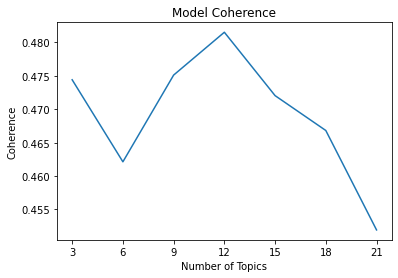

In [44]:
plt.plot(x, y_c)
plt.title('Model Coherence')
plt.xlabel('Number of Topics')
plt.xticks(range(3,22,3))
plt.ylabel('Coherence');
plt.savefig('../img/coherence.png')

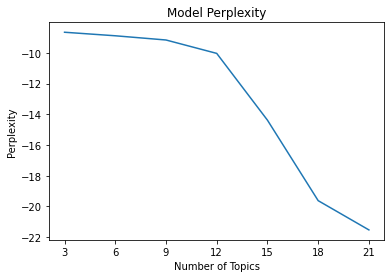

In [45]:
plt.plot(x, np.array(y_p))
plt.title('Model Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(range(3,22,3));
plt.savefig('../img/perplexity.png')

In [ ]:
# model = gensim.models.LdaModel.load('mdl/model2/full_corpus_model')

In [12]:
model.get_document_topics(corpus.gensim_corpus, per_word_topics=True)[50]

([(0, 0.33138776),
  (1, 0.06677586),
  (2, 0.01016437),
  (3, 0.20406939),
  (5, 0.14906803),
  (6, 0.103684165),
  (7, 0.017829698),
  (8, 0.032781985),
  (9, 0.0835679)],
 [],
 [])

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus.gensim_corpus, corpus.gensim_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.353185  0.227301       1        1  32.938654
3      0.200166 -0.370969       2        1  20.081192
5      0.094177  0.031522       3        1  14.697200
6      0.013139  0.034463       4        1  10.663422
9      0.016185  0.005966       5        1   8.508596
1     -0.084274  0.016524       6        1   6.738873
8     -0.117205  0.014485       7        1   3.347177
7     -0.159580  0.014098       8        1   1.864767
2     -0.159172  0.013448       9        1   1.105059
4     -0.156620  0.013162      10        1   0.055060, topic_info=           Term           Freq          Total Category  logprob  loglift
572        hodl  137858.000000  137858.000000  Default  30.0000  30.0000
615         lol  126927.000000  126927.000000  Default  29.0000  29.0000
783      crypto  135141.000000  135141.000000  Default  28.0000  28.0000
50       buying  164365.000000  164365.000000  Default  27.0000  27.0000
3879    hodling  155260.000000  155260.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
31    apartment       0.053205      10.405155  Topic10 -10.5792   2.2286
32         area       0.053205      10.405155  Topic10 -10.5792   2.2286
8       depends       0.053205    1045.389563  Topic10 -10.5792  -2.3812
9           guh       0.053205      11.928635  Topic10 -10.5792   2.0920
20         aapl       0.053205      66.919404  Topic10 -10.5792   0.3674

[349 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
20        1  0.866714  aapl
20        2  0.029887  aapl
20        3  0.014943  aapl
20        4  0.014943  aapl
20        5  0.014943  aapl
...     ...       ...   ...
705       5  0.000257     🥺
705       6  0.000257     🥺
705       7  0.000257     🥺
705       8  0.000257     🥺
705       9  0.000257     🥺

[2862 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 6, 7, 10, 2, 9, 8, 3, 5])

In [14]:
pyLDAvis.save_html(vis,'../img/lda_vis2.html')